In [1]:
import os
import pickle
import pandas as pd
import numpy as  np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.special as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# !pip install pymc

In [3]:
# ! pip install arviz

## Data

In [4]:
DATA_PATH='data/raw/'
df=pd.DataFrame()
for file in os.listdir(DATA_PATH):
    df_=pd.read_csv(f'{DATA_PATH}{file}')
    df=pd.concat([df, df_])
df.shape

(180524, 13)

In [5]:
df.head(10)

EKSAMI_SOORITAJA  KUUPAEV   BYROO KATEGOORIA ERITINGIMUSED  \
0  fb6f44a4e71821f2  2023-01   Valga          B           101   
1  82ed52e5990f8204  2023-01  Jõgeva          B           101   
2  e72eeaf255d74785  2023-01   Narva          B        101|78   
3  d0dd38daf0397c9d  2023-01   Valga          B           101   
4  655194a10a21cd56  2023-01   Paide          B        101|78   
5  761396cbfe80ec42  2023-01   Valga          B           101   
6  de824d8083a1d269  2023-01   Rapla          B           101   
7  44e0c0d162afebb0  2023-01   Narva          B           101   
8  808f4666542a6bc8  2023-01   Narva          B           101   
9  cdc8a8cc2ddeca47  2023-01   Tartu          B        101|78   

             VIIMANE_AUTOKOOL SOIDUOPETAJA_KAASAS     EKSAMINEERIJA  \
0        osaühing Kursus & Ko                   E  bf2b7218d36e2a3d   
1                 OÜ AUTOSÕIT                   E  844452b4e4bac2ef   
2     OSAÜHING ERMAN AUTOKOOL                   E  d67d168bc8d04278   
3        osaühing Kursus & Ko                   J  bf2b7218d36e2a3d   
4           Autokool Drive OÜ                   E  f6097462dafbd97c   
5        osaühing Kursus & Ko                   E  faeaf99580d6be30   
6          Silver Autokool OÜ                   E  4b9e369e12d8f969   
7       Osaühing STALIKA-VEOD                   E  166c8268fe1b2ec1   
8  Mittetulundusühing Autobis                   E  166c8268fe1b2ec1   
9            ROPKA ERAKOOL OÜ                 NaN  c68c6310b2fe1124   

             SEISUND  KESTUS KATK_POHJUS                     MITTEARVESTATUD  \
0   MITTE_SOORITATUD    28.0         NaN          LIIKLUSOHUTUS|TEELPUSIMINE   
1         SOORITATUD    44.0         NaN                                 NaN   
2         SOORITATUD    45.0         NaN                                 NaN   
3   MITTE_SOORITATUD    33.0         NaN                       LIIKLUSOHUTUS   
4   MITTE_SOORITATUD    18.0         NaN                PARKIMINE_MANOOVRIGA   
5         SOORITATUD    42.0         NaN                                 NaN   
6         SOORITATUD    49.0         NaN                                 NaN   
7         SOORITATUD    41.0         NaN                                 NaN   
8   MITTE_SOORITATUD    47.0         NaN  LIIKLUSOHUTUS|PARKIMINE_MANOOVRIGA   
9  EI_ILMUNUD_KOHALE     NaN  EI_ILMUNUD                                 NaN   

                                         VEAD  
0                                         NaN  
1                                         NaN  
2                                         NaN  
3                                         NaN  
4  EBAPIISAV_ETTEVALMISTUS|PARKIMINE_MARGISEL  
5                                         NaN  
6                                         NaN  
7                                         NaN  
8                                  OHUSTAMINE  
9                                         NaN

In [52]:
df.tail(10)

EKSAMI_SOORITAJA  KUUPAEV    BYROO KATEGOORIA ERITINGIMUSED  \
43899  2d3d0275e6f87c93  2024-01  Tallinn          C           NaN   
43900  662c8bfc52935409  2024-08    Tartu          C           NaN   
43901  8431c357abeb9177  2024-05  Tallinn          A           NaN   
43902  41f599b18e8d11a3  2024-09    Rapla          A           NaN   
43903  7ba322b8b5eb8552  2024-02    Pärnu         CE           NaN   
43904  2455ec4557fca42a  2024-02    Jõhvi          C           NaN   
43905  15758d080522a0f9  2024-08  Tallinn          A           NaN   
43906  dd65c5b9c581747f  2024-05  Tallinn          A           NaN   
43907  b9f5d194b08c7496  2024-03    Jõhvi          C           NaN   
43908  4674e35f5ec54f3f  2024-10     Võru          C           NaN   

             VIIMANE_AUTOKOOL SOIDUOPETAJA_KAASAS     EKSAMINEERIJA  \
43899       Aktsiaselts Odium                   E  a1d9e404aeec83d1   
43900             OÜ AUTOSÕIT                   E  b89f5e763b05e7a7   
43901        Ametikoolitus OÜ                   E  b353c311e671711a   
43902       Rapla Autokool OÜ                   E  b353c311e671711a   
43903  osaühing Aide Autokool                   E  c347692cf48342d6   
43904  Tõnis Mägi Autokool OÜ                   E  268b141c418a500d   
43905        Ametikoolitus OÜ                   E  b353c311e671711a   
43906         Sky Autokool OÜ                 NaN  c68c6310b2fe1124   
43907             OÜ AUTOSÕIT                   E  c74b0de43bcd0b0f   
43908        Tugev Partner OÜ                   E  5f2e29794998d365   

                 SEISUND  KESTUS KATK_POHJUS MITTEARVESTATUD           VEAD  
43899         SOORITATUD    58.0         NaN             NaN            NaN  
43900   MITTE_SOORITATUD     4.0         NaN      TAGUR_BOKS  VASTU_KOONUST  
43901         SOORITATUD    44.0         NaN             NaN            NaN  
43902         SOORITATUD    43.0         NaN             NaN            NaN  
43903         SOORITATUD    64.0         NaN             NaN            NaN  
43904         SOORITATUD    53.0         NaN             NaN            NaN  
43905         SOORITATUD    50.0         NaN             NaN            NaN  
43906  EI_ILMUNUD_KOHALE     NaN  EI_ILMUNUD             NaN            NaN  
43907         SOORITATUD    55.0         NaN             NaN            NaN  
43908         SOORITATUD    60.0         NaN             NaN            NaN

In [7]:
df.describe(include='all')

EKSAMI_SOORITAJA  KUUPAEV    BYROO KATEGOORIA ERITINGIMUSED  \
count             180524   180524   180524     180524        129745   
unique             91167       47       17         14            11   
top     2a1562b30ea0f71a  2022-05  Tallinn          B           101   
freq                  23     4792    68889     128633         96651   
mean                 NaN      NaN      NaN        NaN           NaN   
std                  NaN      NaN      NaN        NaN           NaN   
min                  NaN      NaN      NaN        NaN           NaN   
25%                  NaN      NaN      NaN        NaN           NaN   
50%                  NaN      NaN      NaN        NaN           NaN   
75%                  NaN      NaN      NaN        NaN           NaN   
max                  NaN      NaN      NaN        NaN           NaN   

       VIIMANE_AUTOKOOL SOIDUOPETAJA_KAASAS     EKSAMINEERIJA     SEISUND  \
count            170298              175589            180524      180524   
unique              366                   2                59           4   
top         OÜ AUTOSÕIT                   E  bf2b7218d36e2a3d  SOORITATUD   
freq              18021              165004              5320       97720   
mean                NaN                 NaN               NaN         NaN   
std                 NaN                 NaN               NaN         NaN   
min                 NaN                 NaN               NaN         NaN   
25%                 NaN                 NaN               NaN         NaN   
50%                 NaN                 NaN               NaN         NaN   
75%                 NaN                 NaN               NaN         NaN   
max                 NaN                 NaN               NaN         NaN   

               KESTUS KATK_POHJUS MITTEARVESTATUD           VEAD  
count   175214.000000        5320           77419          18738  
unique            NaN           7            2726            418  
top               NaN  EI_ILMUNUD   LIIKLUSOHUTUS  AJA_YLETAMINE  
freq              NaN        3275           11518           2724  
mean        38.991182         NaN             NaN            NaN  
std         18.175641         NaN             NaN            NaN  
min          0.000000         NaN             NaN            NaN  
25%         26.000000         NaN             NaN            NaN  
50%         43.000000         NaN             NaN            NaN  
75%         50.000000         NaN             NaN            NaN  
max       1024.000000         NaN             NaN            NaN

## cols2keep

In [8]:
df_b=df[(df.KATEGOORIA=='B')&(df.SEISUND.isin(['MITTE_SOORITATUD', 'SOORITATUD']))]
df_b.shape

(124702, 13)

In [10]:
COLS2KEEP=['KUUPAEV', 'BYROO', 'ERITINGIMUSED','VIIMANE_AUTOKOOL','SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND']

In [13]:
df_b_sub=df_b[COLS2KEEP]

In [14]:
df_b_sub.head(10)

KUUPAEV   BYROO ERITINGIMUSED            VIIMANE_AUTOKOOL  \
0   2023-01   Valga           101        osaühing Kursus & Ko   
1   2023-01  Jõgeva           101                 OÜ AUTOSÕIT   
2   2023-01   Narva        101|78     OSAÜHING ERMAN AUTOKOOL   
3   2023-01   Valga           101        osaühing Kursus & Ko   
4   2023-01   Paide        101|78           Autokool Drive OÜ   
5   2023-01   Valga           101        osaühing Kursus & Ko   
6   2023-01   Rapla           101          Silver Autokool OÜ   
7   2023-01   Narva           101       Osaühing STALIKA-VEOD   
8   2023-01   Narva           101  Mittetulundusühing Autobis   
10  2023-01   Valga           101                 OÜ AUTOSÕIT   

   SOIDUOPETAJA_KAASAS     EKSAMINEERIJA           SEISUND  
0                    E  bf2b7218d36e2a3d  MITTE_SOORITATUD  
1                    E  844452b4e4bac2ef        SOORITATUD  
2                    E  d67d168bc8d04278        SOORITATUD  
3                    J  bf2b7218d36e2a3d  MITTE_SOORITATUD  
4                    E  f6097462dafbd97c  MITTE_SOORITATUD  
5                    E  faeaf99580d6be30        SOORITATUD  
6                    E  4b9e369e12d8f969        SOORITATUD  
7                    E  166c8268fe1b2ec1        SOORITATUD  
8                    E  166c8268fe1b2ec1  MITTE_SOORITATUD  
10                   E  ae264be409f2ca9f        SOORITATUD

In [53]:
df_b_sub.tail(10)

KUUPAEV     BYROO ERITINGIMUSED        VIIMANE_AUTOKOOL  \
43824  2024-03  Haapsalu           NaN                 UNKNOWN   
43825  2024-07     Valga           NaN                 UNKNOWN   
43850  2024-03     Tartu           NaN         VPK Koolitus OÜ   
43855  2024-03     Tartu           NaN         VPK Koolitus OÜ   
43858  2024-10     Narva           NaN                 UNKNOWN   
43860  2024-10    Kärdla           NaN     Aivar Tärk Autokool   
43861  2024-06     Pärnu           NaN                 UNKNOWN   
43869  2024-04     Pärnu           NaN  osaühing Aide Autokool   
43871  2024-08     Tartu           NaN         VPK Koolitus OÜ   
43882  2024-11     Tartu           NaN         VPK Koolitus OÜ   

      SOIDUOPETAJA_KAASAS     EKSAMINEERIJA           SEISUND    y  \
43824                   J  31451a368e962058        SOORITATUD  1.0   
43825                   E  844452b4e4bac2ef        SOORITATUD  1.0   
43850                   E  b89f5e763b05e7a7        SOORITATUD  1.0   
43855                   E  5f2e29794998d365        SOORITATUD  1.0   
43858                   E  166c8268fe1b2ec1        SOORITATUD  1.0   
43860                   E  31451a368e962058        SOORITATUD  1.0   
43861                   E  c347692cf48342d6  MITTE_SOORITATUD  0.0   
43869                   E  12ed0758e403a7d6        SOORITATUD  1.0   
43871                   E  b89f5e763b05e7a7        SOORITATUD  1.0   
43882                   E  ea58f592917668cf        SOORITATUD  1.0   

       y_transformed  year  ...  year_idx  dow_idx  EKSAMINEERIJA_CLEAN  \
43824       0.999999  2024  ...         3        6     31451a368e962058   
43825       0.999999  2024  ...         3        3     844452b4e4bac2ef   
43850       0.999999  2024  ...         3        6     b89f5e763b05e7a7   
43855       0.999999  2024  ...         3        6     5f2e29794998d365   
43858       0.999999  2024  ...         3        5     166c8268fe1b2ec1   
43860       0.999999  2024  ...         3        5     31451a368e962058   
43861       0.000001  2024  ...         3        2     c347692cf48342d6   
43869       0.999999  2024  ...         3        3     12ed0758e403a7d6   
43871       0.999999  2024  ...         3        4     b89f5e763b05e7a7   
43882       0.999999  2024  ...         3        6     ea58f592917668cf   

       examiner_idx  school_idx  passed  byroo_idx  eri_101  eri_78  eri_96  
43824            22          10       1         13        1       1       1  
43825             1          10       1          0        1       1       1  
43850            13          21       1          5        1       1       1  
43855            41          21       1          5        1       1       1  
43858             6          10       1          2        1       1       1  
43860            22         197       1         15        1       1       1  
43861            35          10       0         14        1       1       1  
43869            23         118       1         14        1       1       1  
43871            13          21       1          5        1       1       1  
43882            31          21       1          5        1       1       1  

[10 rows x 29 columns]

In [15]:
# df_b_sub.head(10).to_dict()

In [16]:
df_b_sub.describe(include='all')

KUUPAEV    BYROO ERITINGIMUSED VIIMANE_AUTOKOOL SOIDUOPETAJA_KAASAS  \
count    124702   124702        120919           120021              124702   
unique       47       17             7              353                   2   
top     2022-03  Tallinn           101      OÜ AUTOSÕIT                   E   
freq       3389    47397         91516            12700              115230   

           EKSAMINEERIJA           SEISUND  
count             124702            124702  
unique                58                 2  
top     c6d0f1ea0c1f7aec  MITTE_SOORITATUD  
freq                5024             64273

In [17]:
df_b_sub.SEISUND.value_counts()

SEISUND
MITTE_SOORITATUD    64273
SOORITATUD          60429
Name: count, dtype: int64

In [18]:
df_b[df_b.SEISUND=='KATKESTATUD']

Empty DataFrame
Columns: [EKSAMI_SOORITAJA, KUUPAEV, BYROO, KATEGOORIA, ERITINGIMUSED, VIIMANE_AUTOKOOL, SOIDUOPETAJA_KAASAS, EKSAMINEERIJA, SEISUND, KESTUS, KATK_POHJUS, MITTEARVESTATUD, VEAD]
Index: []

## Recode y

In [19]:
df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})

/tmp/ipykernel_822/645445151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})
/tmp/ipykernel_822/645445151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})


In [20]:
epsilon = 1e-6  # small constant
df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon

/tmp/ipykernel_822/4272676741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon


## Extract time variables

In [21]:
df_b_sub['year']=pd.to_datetime(df_b_sub.KUUPAEV).dt.year
df_b_sub['week']=pd.to_datetime(df_b_sub.KUUPAEV).dt.isocalendar().week
df_b_sub['month']=pd.to_datetime(df_b_sub.KUUPAEV).dt.month
df_b_sub['dow']=pd.to_datetime(df_b_sub.KUUPAEV).dt.dayofweek

/tmp/ipykernel_822/1433284352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['year']=pd.to_datetime(df_b_sub.KUUPAEV).dt.year
/tmp/ipykernel_822/1433284352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['week']=pd.to_datetime(df_b_sub.KUUPAEV).dt.isocalendar().week
/tmp/ipykernel_822/1433284352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [22]:
# Now create the cyclical features for month
df_b_sub['month_sin'] = np.sin(2 * np.pi * df_b_sub['month']/12)
df_b_sub['month_cos'] = np.cos(2 * np.pi * df_b_sub['month']/12)

# Let's look at the first few rows to see the result
df_b_sub[['KUUPAEV', 'month', 'month_sin', 'month_cos']].head()

KUUPAEV  month  month_sin  month_cos
0  2023-01      1        0.5   0.866025
1  2023-01      1        0.5   0.866025
2  2023-01      1        0.5   0.866025
3  2023-01      1        0.5   0.866025
4  2023-01      1        0.5   0.866025

In [23]:
# Create cyclical features for week
df_b_sub['week_sin'] = np.sin(2 * np.pi * df_b_sub['week']/52)
df_b_sub['week_cos'] = np.cos(2 * np.pi * df_b_sub['week']/52)

In [24]:
# Create cyclical features for week
df_b_sub['day_sin'] = np.sin(2 * np.pi * df_b_sub['dow']/7)
df_b_sub['day_cos'] = np.cos(2 * np.pi * df_b_sub['dow']/7)

<Axes: xlabel='week'>

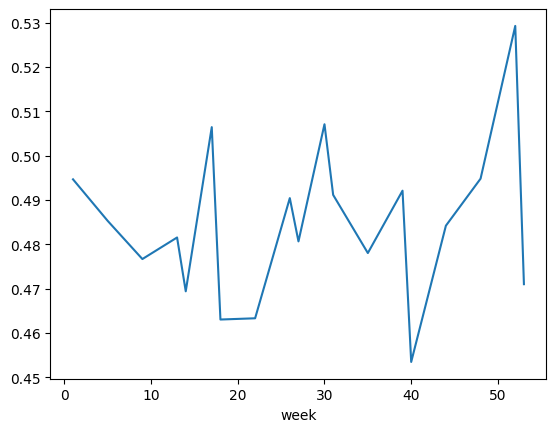

In [25]:
df_b_sub.groupby(['week'])['y'].mean().plot()

<Axes: xlabel='month'>

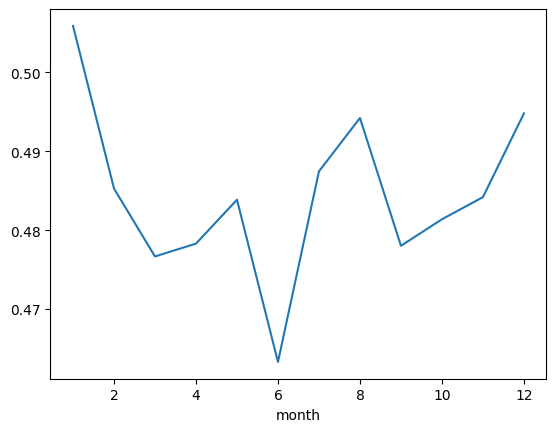

In [26]:
df_b_sub.groupby(['month'])['y'].mean().plot()

<Axes: xlabel='week'>

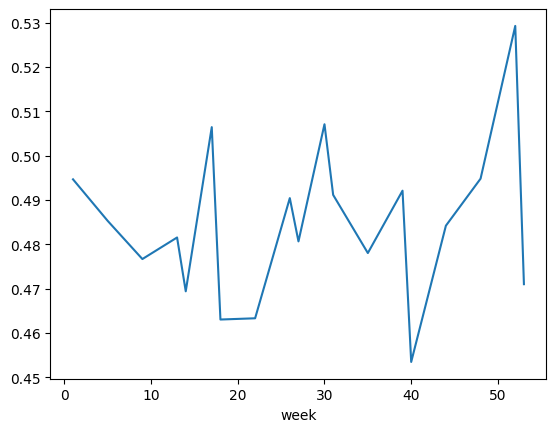

In [27]:
df_b_sub.groupby(['week'])['y'].mean().plot()

<Axes: xlabel='dow'>

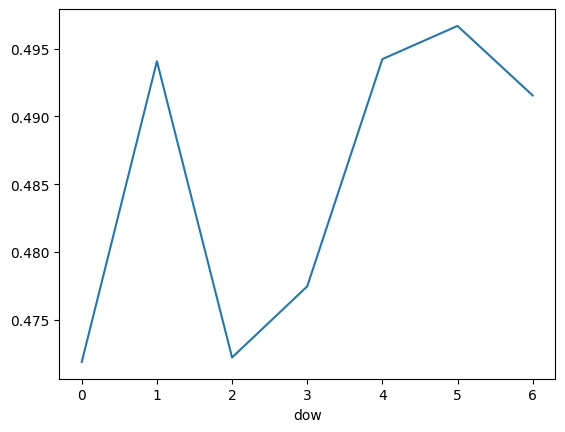

In [28]:
df_b_sub.groupby(['dow'])['y'].mean().plot()

In [29]:
df_b_sub.groupby(['year'])['y'].mean()

year
2021    0.477491
2022    0.504322
2023    0.478739
2024    0.475784
Name: y, dtype: float64

In [30]:
df_b_sub.dow.value_counts()

dow
0    22264
4    21055
2    18282
3    17723
1    17384
5    14150
6    13844
Name: count, dtype: int64

In [31]:
time_features = ['month_sin', 'month_cos']
df_b_sub[time_features] = (df_b_sub[time_features] - df_b_sub[time_features].mean()) / df_b_sub[time_features].std()

## Make year feature

In [32]:
# Center the years (subtract mean) to make interpretation easier
# First, create year index mapping
year_to_idx = {year: idx for idx, year in enumerate(df_b_sub['year'].unique())}
idx_to_year={v:k for k,v in year_to_idx.items()}
n_years = len(year_to_idx)

# Add year index to dataframe
df_b_sub['year_idx'] = df_b_sub['year'].map(year_to_idx)

## Day of week feature

In [33]:
dow_to_idx = {year: idx for idx, year in enumerate(df_b_sub['dow'].unique())}
idx_to_dow={v:k for k,v in dow_to_idx.items()}
n_dows = len(dow_to_idx)

# Add year index to dataframe
df_b_sub['dow_idx'] = df_b_sub['dow'].map(dow_to_idx)

## Recode others

In [34]:
# Fill missing values with 'UNKNOWN'
df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')

count_examiner=df_b_sub['EKSAMINEERIJA'].str.lower().value_counts()
examiners2keep=count_examiner[count_examiner>20].index
df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')
# Create numeric indices for categorical variables
examiner_to_idx = {examiner: idx for idx, examiner in enumerate(df_b_sub['EKSAMINEERIJA_CLEAN'].unique())}
idx_to_examiner={v:k for k,v in examiner_to_idx.items()}
school_to_idx = {school: idx for idx, school in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].str.lower().unique())}
idx_to_school={v:k for k,v in school_to_idx.items()}

# Convert categories to indices
df_b_sub['examiner_idx'] = df_b_sub['EKSAMINEERIJA_CLEAN'].map(examiner_to_idx)
df_b_sub['school_idx'] = df_b_sub['VIIMANE_AUTOKOOL'].str.lower().map(school_to_idx)

# Convert target to binary
df_b_sub['passed'] = (df_b_sub['SEISUND'] == 'SOORITATUD').astype(int)

In [35]:
count_schools=df_b_sub['VIIMANE_AUTOKOOL'].str.lower().value_counts()
count_schools[count_schools>20]

VIIMANE_AUTOKOOL
oü autosõit                              12700
unknown                                   4681
osaühing aide autokool                    4663
atlanta autokool oü                       4051
aktsiaselts odium                         3591
                                         ...  
vana-vigala tehnika- ja teeninduskool       23
trestem oü                                  23
osaühing kalju autokool                     22
a-autom, oü                                 21
oü horizontrans                             21
Name: count, Length: 227, dtype: int64

In [36]:
#count_examiner#[count_examiner>20]

In [37]:
# First create index mapping for BYROO
byroo_to_idx = {byroo: idx for idx, byroo in enumerate(df_b_sub['BYROO'].unique())}
idx_to_byroo={v:k for k,v in byroo_to_idx.items()}

n_byroos = len(byroo_to_idx)

# Convert BYROO to indices
df_b_sub['byroo_idx'] = df_b_sub['BYROO'].map(byroo_to_idx)

In [38]:
# Get dimensions for our hierarchical components
n_examiners = len(examiner_to_idx)
n_schools = len(school_to_idx)

In [39]:
n_examiners

56

## Soiduopetaja kaasas

In [40]:
df_b_sub.groupby('SOIDUOPETAJA_KAASAS')['y'].mean()

SOIDUOPETAJA_KAASAS
E    0.491999
J    0.394426
Name: y, dtype: float64

## Eritingimus

In [42]:
df_b_sub.ERITINGIMUSED.value_counts()

ERITINGIMUSED
101          91516
101|78       26989
78            1263
96            1121
101|78|78       27
78|96            2
78|78            1
Name: count, dtype: int64

In [44]:
df_b_sub['eri_101']=np.where(df_b_sub.ERITINGIMUSED.str.contains('101'), 1, 0)
df_b_sub['eri_78']=np.where(df_b_sub.ERITINGIMUSED.str.contains('78'), 1, 0)

In [45]:
df_b_sub['eri_96']=np.where(df_b_sub.ERITINGIMUSED.str.contains('96'), 1, 0)

<Axes: ylabel='ERITINGIMUSED'>

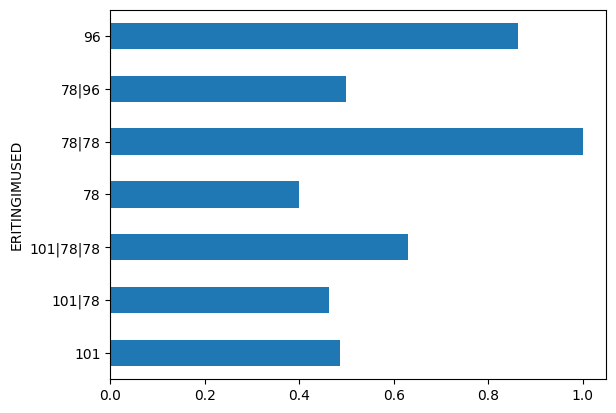

In [48]:
df_b_sub.groupby('ERITINGIMUSED')['y'].mean().plot(kind='barh')

<Axes: ylabel='eri_101'>

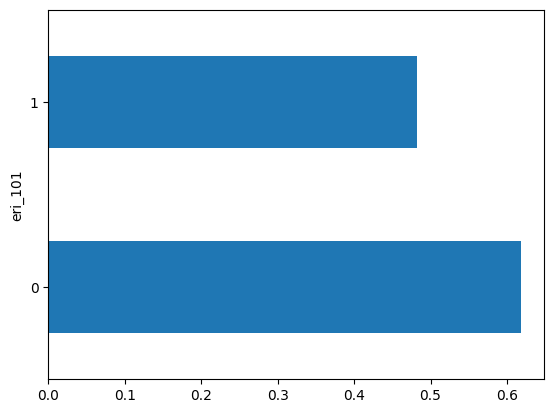

In [49]:
df_b_sub.groupby('eri_101')['y'].mean().plot(kind='barh')

<Axes: ylabel='eri_78'>

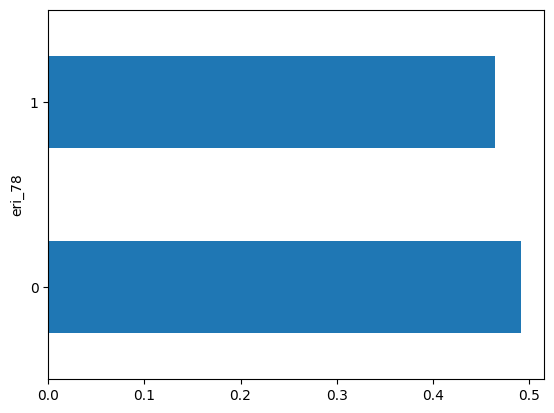

In [50]:
df_b_sub.groupby('eri_78')['y'].mean().plot(kind='barh')

<Axes: ylabel='eri_96'>

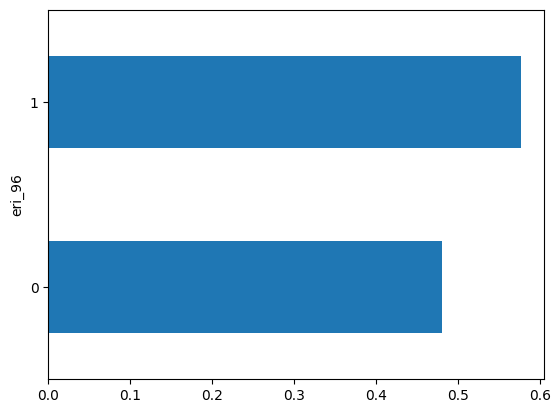

In [51]:
df_b_sub.groupby('eri_96')['y'].mean().plot(kind='barh')

In [54]:
pd.isnull(df_b_sub.ERITINGIMUSED).sum()

3783

## Model

In [40]:
# Create the model
with pm.Model() as model:
    # Global intercept
    #intercept = pm.Normal('intercept', mu=0, sigma=0.1)
    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1)
    intercept_sigma = pm.HalfStudentT('intercept_sigma', nu=3, sigma=0.05)
    intercept = pm.Deterministic('intercept', intercept_raw * intercept_sigma)
    
    # Hierarchical priors for examiners and schools
    examiner_sigma = pm.HalfCauchy('examiner_sigma', beta=0.1)
    examiner_raw = pm.Normal('examiner_raw', mu=0, sigma=1, shape=n_examiners)
    examiner_effects = pm.Deterministic('examiner_effects', examiner_raw * examiner_sigma)
    
    #school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    #school_effects = pm.Normal('school_effects', mu=0, sigma=school_sigma, shape=n_schools)
    # Non-centered parameterization for schools
    school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    school_raw = pm.Normal('school_raw', mu=0, sigma=1, shape=n_schools)
    school_effects = pm.Deterministic('school_effects', school_raw * school_sigma)
    
    #byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    #byroo_effects = pm.Normal('byroo_effects', mu=0, sigma=byroo_sigma, shape=n_byroos)
    # Non-centered parameterization for byroo
    byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    byroo_raw = pm.Normal('byroo_raw', mu=0, sigma=1, shape=n_byroos)
    byroo_effects = pm.Deterministic('byroo_effects', byroo_raw * byroo_sigma)
    
    # Categorical year effects
    year_sigma = pm.HalfStudentT('year_sigma', nu=3, sigma=0.1)
    year_raw = pm.Normal('year_raw', mu=0, sigma=1, shape=n_years)
    year_effects = pm.Deterministic('year_effects', year_raw * year_sigma)
    
    dow_sigma = pm.HalfStudentT('dow_sigma', nu=3, sigma=0.5)
    dow_raw = pm.Normal('dow_raw', mu=0, sigma=1, shape=n_dows)
    dow_effects = pm.Deterministic('dow_effects', dow_raw * dow_sigma)
    
    # Combined time effects with tighter prior
    time_betas = pm.Normal('time_betas', mu=0, sigma=0.5, shape=len(time_features))
    
    # Combine all predictors
    logit = (intercept + 
             examiner_effects[df_b_sub['examiner_idx']] +
             school_effects[df_b_sub['school_idx']] +
             byroo_effects[df_b_sub['byroo_idx']] +
             year_effects[df_b_sub['year_idx']] +
             dow_effects[df_b_sub['dow_idx']] +
             pm.math.dot(df_b_sub[time_features].values.astype(float), time_betas)
            )
        
     # Transform mu to be between 0 and 1
    mu_bounded = pm.math.invlogit(logit)
    
    # Use transformed data with Beta likelihood
    alpha = pm.HalfNormal('alpha', sigma=1)
    y = pm.Beta('y', 
                    alpha=mu_bounded*alpha, 
                    beta=(1-mu_bounded)*alpha, 
                    observed=df_b_sub['y_transformed'])

## Sample

In [41]:
with model:
    # Initialize the sampler
    # Using NUTS (No U-Turn Sampler) which is good for continuous parameters
    trace = pm.sample(
        draws=4000,          # Number of samples to draw
        tune=4000,           # Number of tuning steps
        chains=4,            # Number of chains to run
        init='advi',  
        return_inferencedata=True,
        target_accept=0.95    # Target acceptance rate
    )

Initializing NUTS using advi...


Output()

Convergence achieved at 31000
Interrupted at 30,999 [15%]: Average Loss = -1.1387e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_raw, intercept_sigma, examiner_sigma, examiner_raw, school_sigma, school_raw, byroo_sigma, byroo_raw, year_sigma, year_raw, dow_sigma, dow_raw, time_betas, alpha]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 13694 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnostic

In [42]:
# Check basic convergence statistics
df_summary=az.summary(trace)

In [43]:
df_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept_raw   -0.082  0.832  -1.707    1.512      0.021    0.015    1510.0   
examiner_raw[0]  1.323  0.230   0.914    1.768      0.007    0.005    1129.0   
examiner_raw[1]  2.307  0.272   1.794    2.823      0.010    0.007     684.0   
examiner_raw[2] -0.476  0.186  -0.824   -0.129      0.007    0.005     813.0   
examiner_raw[3] -1.295  0.187  -1.648   -0.949      0.007    0.005     751.0   
...                ...    ...     ...      ...        ...      ...       ...   
dow_effects[2]   0.016  0.013  -0.007    0.042      0.000    0.000    7358.0   
dow_effects[3]  -0.019  0.013  -0.045    0.002      0.000    0.000    5854.0   
dow_effects[4]  -0.007  0.012  -0.030    0.017      0.000    0.000    6424.0   
dow_effects[5]  -0.004  0.012  -0.028    0.019      0.000    0.000    7238.0   
dow_effects[6]   0.014  0.012  -0.007    0.038      0.000    0.000    6105.0   

                 ess_tail  r_hat  
intercept_raw      2744.0    1.0  
examiner_raw[0]    2006.0    1.0  
examiner_raw[1]    1169.0    1.0  
examiner_raw[2]    1600.0    1.0  
examiner_raw[3]    2447.0    1.0  
...                   ...    ...  
dow_effects[2]    10360.0    1.0  
dow_effects[3]     4369.0    1.0  
dow_effects[4]     6060.0    1.0  
dow_effects[5]     9089.0    1.0  
dow_effects[6]     9100.0    1.0  

[887 rows x 9 columns]

In [44]:
df_summary[df_summary.r_hat>1.05].shape

(0, 9)

In [45]:
df_summary[df_summary.r_hat>1.01].shape

(0, 9)


Model Parameter Summary:


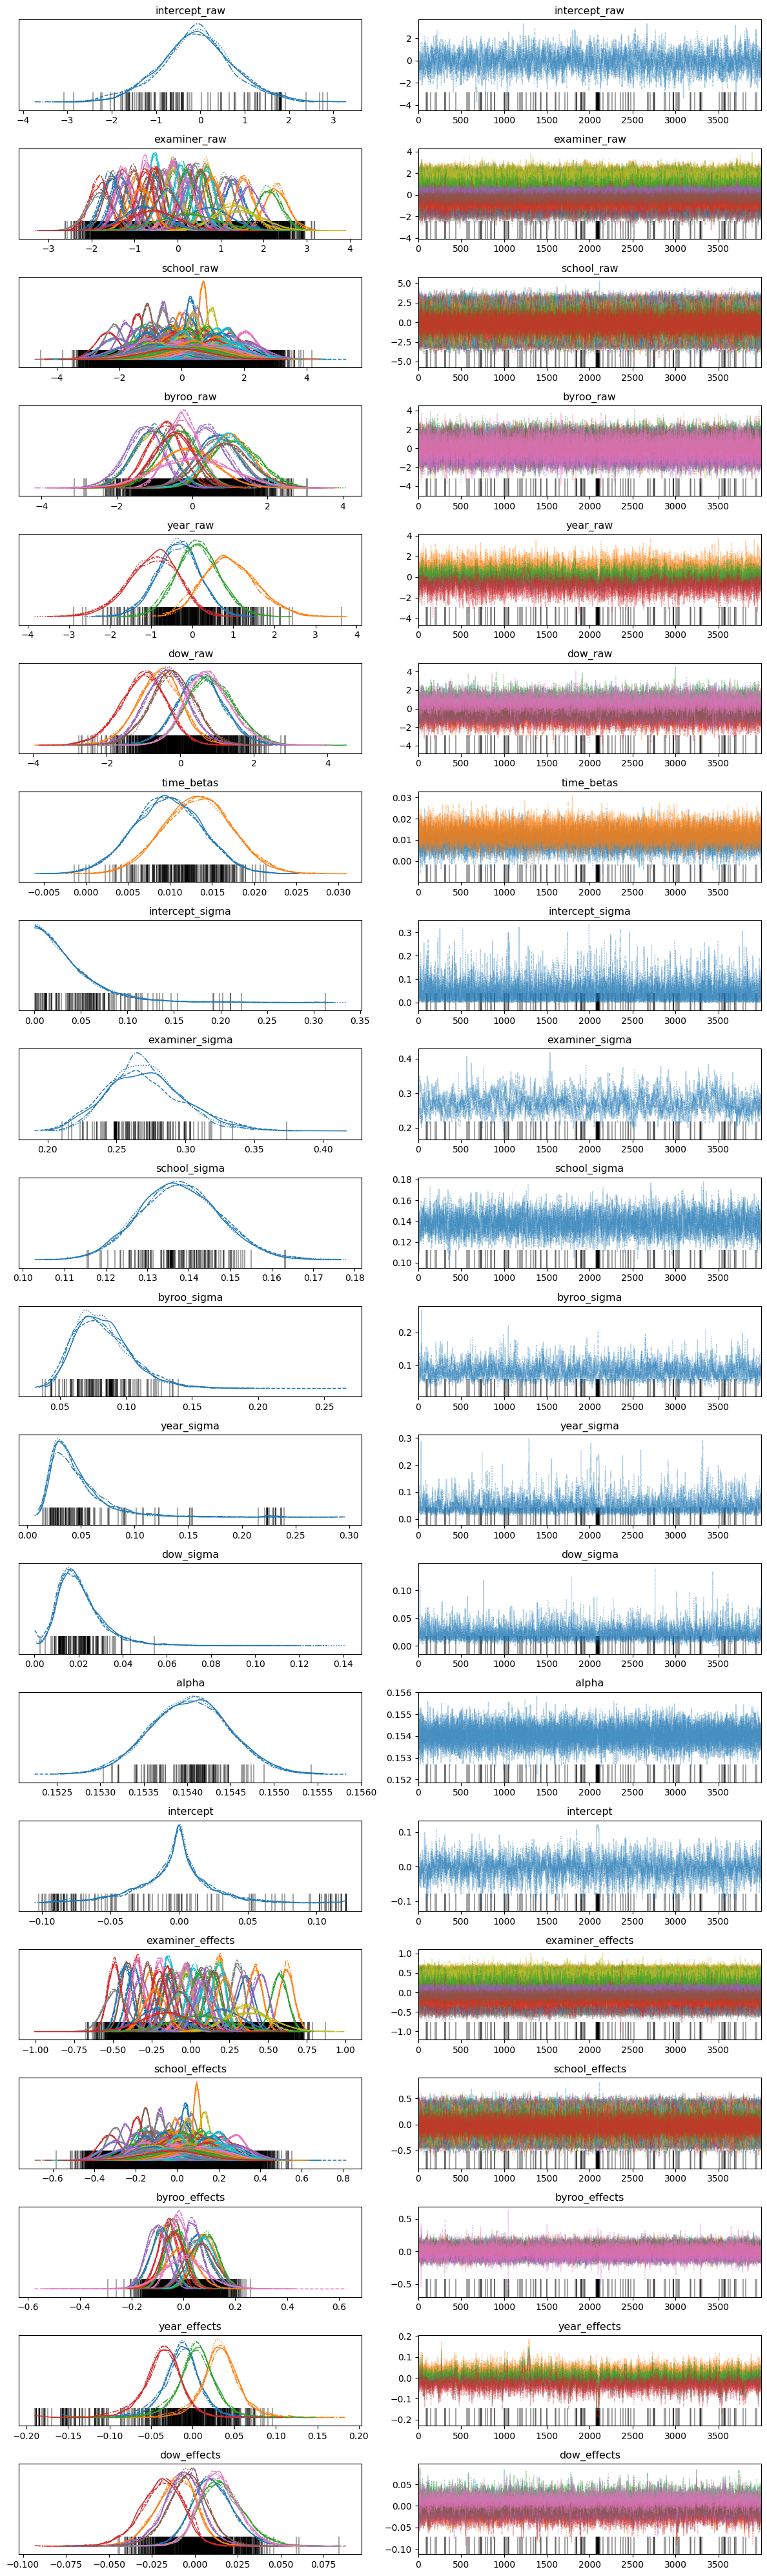

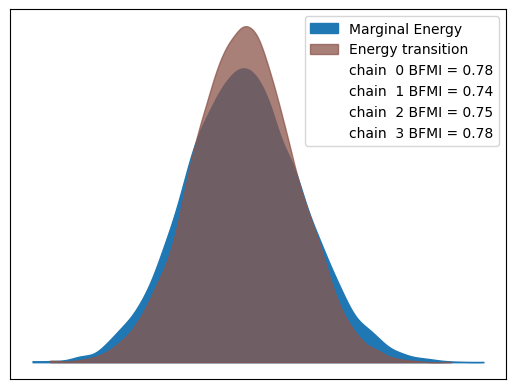


Number of divergent samples:
<xarray.DataArray 'diverging' ()> Size: 8B
array(143)


In [46]:
# Basic convergence diagnostics
print("\nModel Parameter Summary:")
summary = az.summary(trace, kind='diagnostics')

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot energy diagnostics
az.plot_energy(trace)
plt.show()

# Check for divergences
print("\nNumber of divergent samples:")
print(trace.sample_stats.diverging.sum())

In [47]:
df_summary[df_summary.r_hat>1.01]

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []

## Save trace

In [48]:
# Save as netCDF file (recommended)
trace.to_netcdf("models/soidueksam_b_kat_multiyear.nc")

# Or save as pickle file

with open('models/soidueksam_b_kat_multiyear.pkl', 'wb') as buff:
    pickle.dump(trace, buff)

## Load trace

In [40]:
trace = az.from_netcdf("models/soidueksam_b_kat_multiyear.nc")

## overall exam success

In [49]:
def get_average_success_probability(trace):
    # Get intercept (baseline)
    intercept = trace.posterior['intercept'].values
    
    # Convert to probability using inverse logit
    baseline_prob = 1 / (1 + np.exp(-intercept))
    
    # Calculate summary statistics
    results = {
        'mean': np.mean(baseline_prob),
        'std': np.std(baseline_prob),
        'lower_ci': np.percentile(baseline_prob, 2.5),
        'upper_ci': np.percentile(baseline_prob, 97.5)
    }
    
    print("Overall Success Probability:")
    print(f"Mean: {results['mean']:.3f}")
    print(f"95% CI: [{results['lower_ci']:.3f}, {results['upper_ci']:.3f}]")
    
    return results

average_prob = get_average_success_probability(trace)
average_prob

Overall Success Probability:
Mean: 0.499
95% CI: [0.483, 0.513]


{'mean': 0.49908716405664116,
 'std': 0.006767509633874981,
 'lower_ci': 0.48330724035730505,
 'upper_ci': 0.5130564918830994}

In [50]:
df_b_sub.y.mean()

0.48458725601834773

## Factors that contribute the most

<Figure size 1800x500 with 0 Axes>

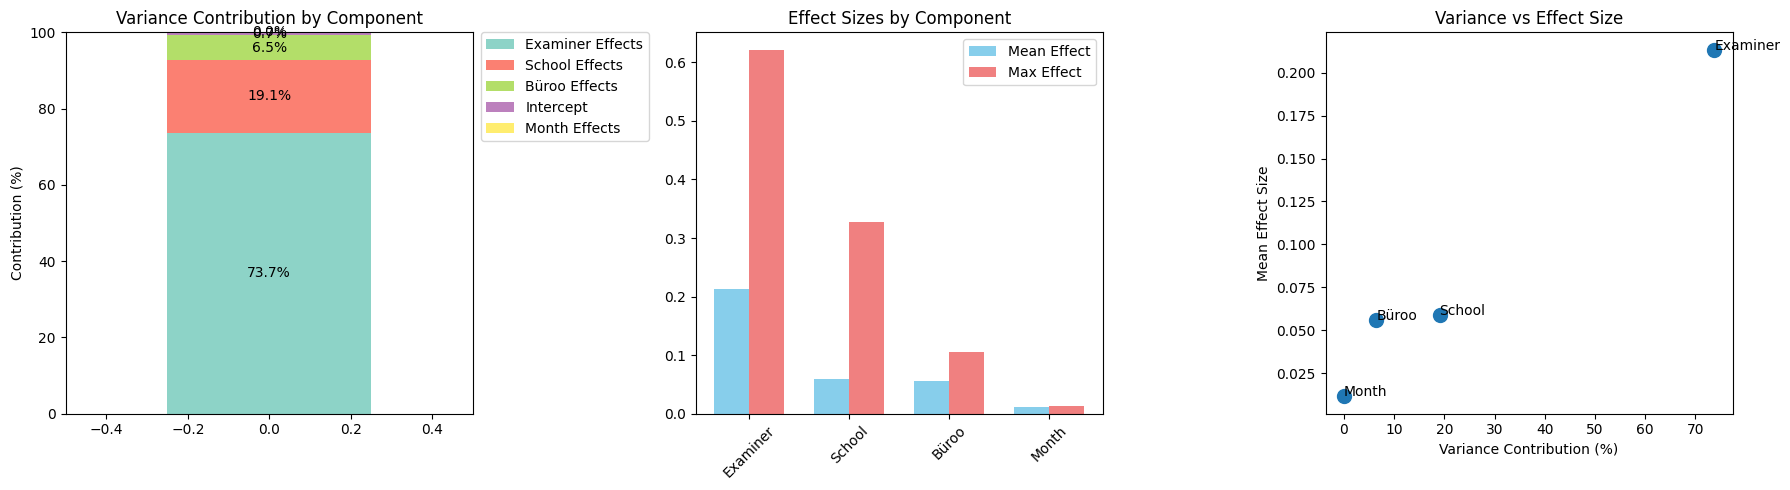

In [51]:
def analyze_component_contributions(trace):
    # Get components
    intercept_var = np.var(trace.posterior['intercept'].values)
    examiner_var = np.var(trace.posterior['examiner_effects'].values.reshape(-1))
    school_var = np.var(trace.posterior['school_effects'].values.reshape(-1))
    byroo_var = np.var(trace.posterior['byroo_effects'].values.reshape(-1))
    time_var = np.var(trace.posterior['time_betas'].values.reshape(-1))

    
    # Calculate total variance
    total_var = intercept_var + examiner_var + school_var + byroo_var + time_var
    
    # Calculate proportions
    contributions = pd.Series({
        'Intercept': intercept_var/total_var,
        'Examiner Effects': examiner_var/total_var,
        'School Effects': school_var/total_var,
        'Büroo Effects': byroo_var/total_var,
        'Month Effects':time_var/total_var,
    })
    
    return contributions * 100  # Convert to percentages

def analyze_effect_sizes(trace, return_df=False):
    # Get absolute mean effects
    examiner_effects = np.abs(np.mean(trace.posterior['examiner_effects'].values, axis=(0,1)))
    school_effects = np.abs(np.mean(trace.posterior['school_effects'].values, axis=(0,1)))
    byroo_effects = np.abs(np.mean(trace.posterior['byroo_effects'].values, axis=(0,1)))
    month_effects = np.abs(np.mean(trace.posterior['time_betas'].values, axis=(0,1)))

    result={
        'Examiner': {'mean': examiner_effects.mean(), 'max': examiner_effects.max()},
        'School': {'mean': school_effects.mean(), 'max': school_effects.max()},
        'Büroo': {'mean': byroo_effects.mean(), 'max': byroo_effects.max()},
        'Month': {'mean': month_effects.mean(), 'max': month_effects.max()}
    }
    
    if return_df:
        return pd.DataFrame(result)
    return result


def plot_model_contributions(trace):
    # Get contributions
    contributions = analyze_component_contributions(trace)
    contributions=contributions.sort_values(ascending=False)
    
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # 1. Stacked Bar Plot
    plt.subplot(131)
    colors = plt.cm.Set3(np.linspace(0, 1, len(contributions)))
    
    # Create bars one by one to properly set up legend
    bottom = 0
    bars = []
    for i, (name, value) in enumerate(contributions.items()):
        bar = plt.bar(0, value, bottom=bottom, color=colors[i], width=0.5, label=name)
        plt.text(0, bottom + value/2, f'{value:.1f}%', ha='center', va='center')
        bottom += value
        bars.append(bar)
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 100)
    plt.ylabel('Contribution (%)')
    plt.title('Variance Contribution by Component')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.02, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # 2. Bar Plot with Effect Sizes
    effect_sizes = analyze_effect_sizes(trace)
    plt.subplot(132)
    components = list(effect_sizes.keys())
    means = [d['mean'] for d in effect_sizes.values()]
    maxes = [d['max'] for d in effect_sizes.values()]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, means, width, label='Mean Effect', color='skyblue')
    plt.bar(x + width/2, maxes, width, label='Max Effect', color='lightcoral')
    plt.xticks(x, components, rotation=45)
    plt.title('Effect Sizes by Component')
    plt.legend()
    
    # 3. Scatter Plot: Variance vs Mean Effect
    plt.subplot(133)
    # Map component names to contribution names
    name_map = {
        'Examiner': 'Examiner Effects',
        'Büroo': 'Büroo Effects',
        'School': 'School Effects',
        'Month': 'Month Effects'
        
    }
    matched_contributions = [contributions[name_map[c]] for c in components]
    
    plt.scatter(matched_contributions, means, s=100)
    for i, txt in enumerate(components):
        plt.annotate(txt, (matched_contributions[i], means[i]))
    plt.xlabel('Variance Contribution (%)')
    plt.ylabel('Mean Effect Size')
    plt.title('Variance vs Effect Size')
    
    plt.tight_layout()
    plt.show()
    
plot_model_contributions(trace)

## Visualize effect contributions


Probability changes:
Intercept: -0.001
Examiner: 0.088
School: -0.005
Bureau: 0.013
Time: 0.006

Final probability: 0.601
Actual outcome: 0.000


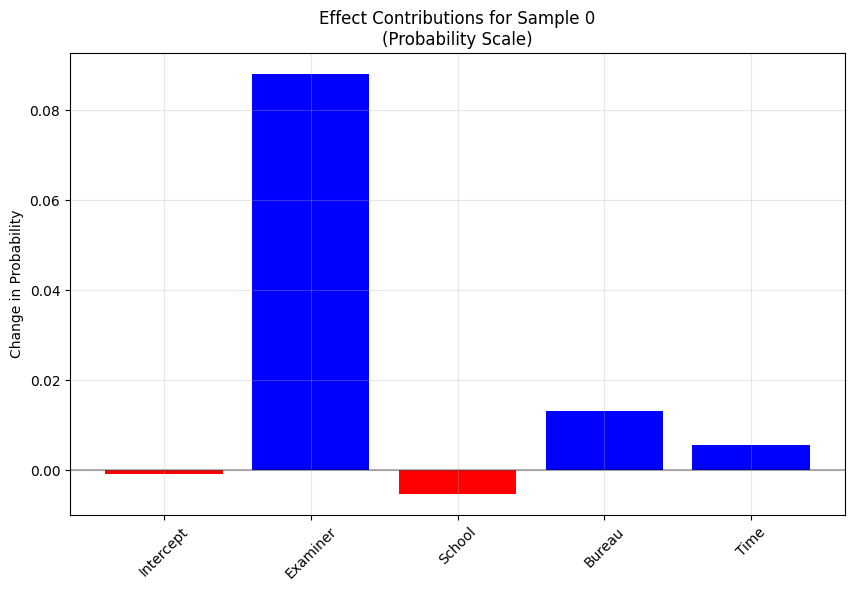

In [52]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
time_effects_mean = np.dot(df_b_sub[time_features], trace.posterior['time_betas'].mean(dim=('chain', 'draw')))
intercept_mean = float(trace.posterior['intercept'].mean())

def plot_effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_mean,
        'Examiner': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'School': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Bureau': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Time': time_effects_mean[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        prob_changes[k] = new_prob - prev_prob
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['blue' if v >= 0 else 'red' for v in prob_changes.values()]
    plt.bar(prob_changes.keys(), prob_changes.values(), color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Effect Contributions for Sample {sample_idx}\n(Probability Scale)')
    plt.ylabel('Change in Probability')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Print values
    print("\nProbability changes:")
    for k, v in prob_changes.items():
        print(f"{k}: {v:.3f}")
    print(f"\nFinal probability: {sp.expit(sum(effects.values())):.3f}")
    print(f"Actual outcome: {df_b_sub['y_transformed'].iloc[sample_idx]:.3f}")
    
plot_effects_breakdown_prob(0)


Probability changes:
Intercept: -0.001
Examiner: 0.150
School: 0.021
Bureau: 0.018
Time: 0.005

Final probability: 0.694
Actual outcome: 1.000


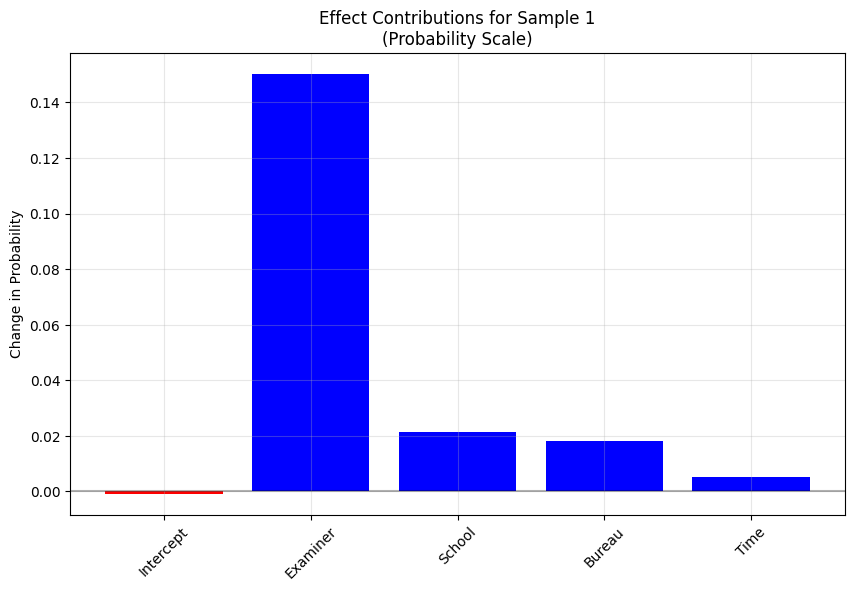

In [53]:
plot_effects_breakdown_prob(1)


Probability changes:
Intercept: -0.001
Examiner: -0.051
School: -0.021
Bureau: -0.005
Time: 0.006

Final probability: 0.429
Actual outcome: 1.000


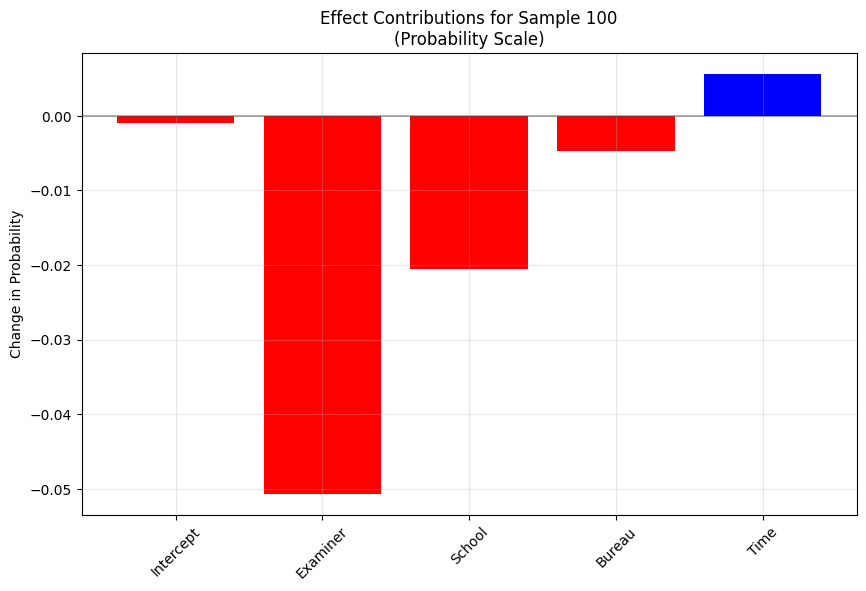

In [54]:
plot_effects_breakdown_prob(100)

## Examiner effects

Number of examiner_idx with significant positive effect: 17
Number of examiner_idx with significant negative effect: 19


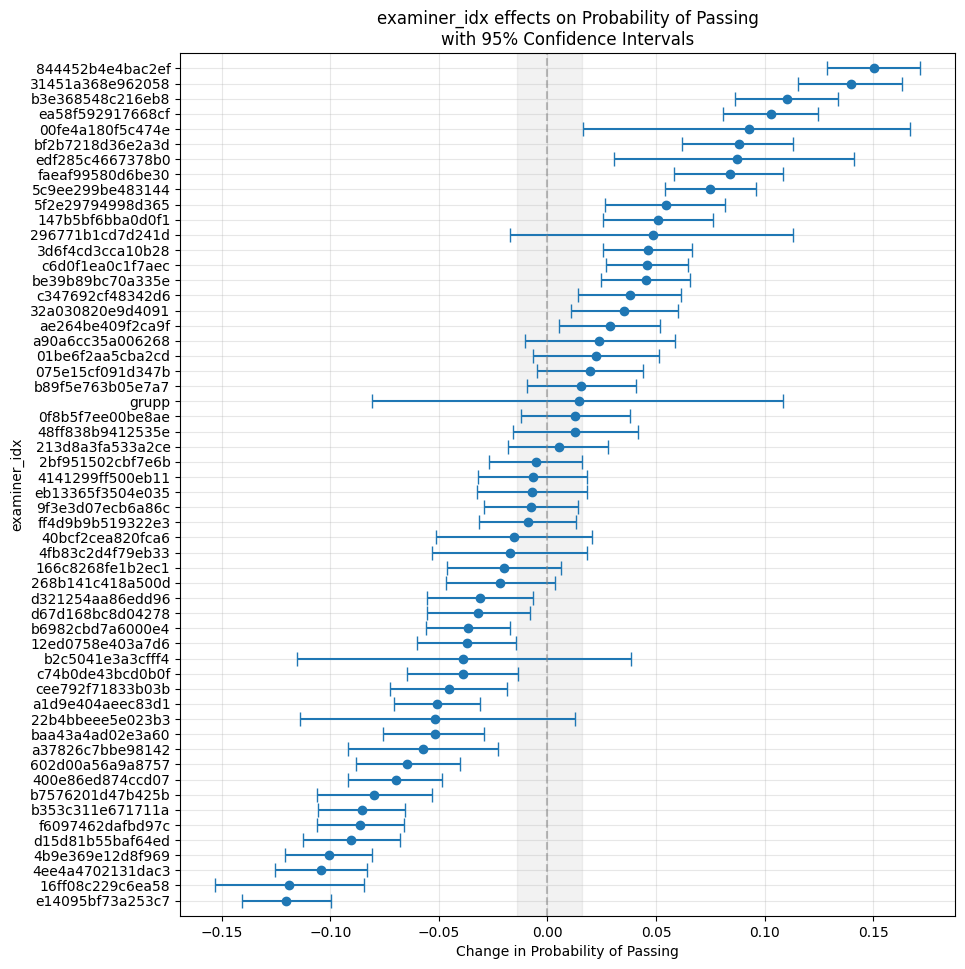

In [79]:
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_mean)
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_mean + effect_samples) - base_prob
        percentiles=np.percentile(prob_changes, [2.5, 97.5])
        if only_significant and ((percentiles[0]<0.0 and percentiles[1]<0.0) or (percentiles[0]>0.0 and percentiles[1]>0.0)):
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan(-base_ci[1] + base_prob, -base_ci[0] + base_prob, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means, range(len(means)),
                xerr=[means - hdis[:, 0], hdis[:, 1] - means],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    # Add examiner IDs to y-axis
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
     # Adjust y-axis limits to remove extra margins
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Change in Probability of Passing')
    plt.title(f'{y_labels_col} effects on Probability of Passing\nwith 95% Confidence Intervals')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    
plot_effects(y_dict=idx_to_examiner)

## School effects

Number of school_idx with significant positive effect: 29
Number of school_idx with significant negative effect: 28


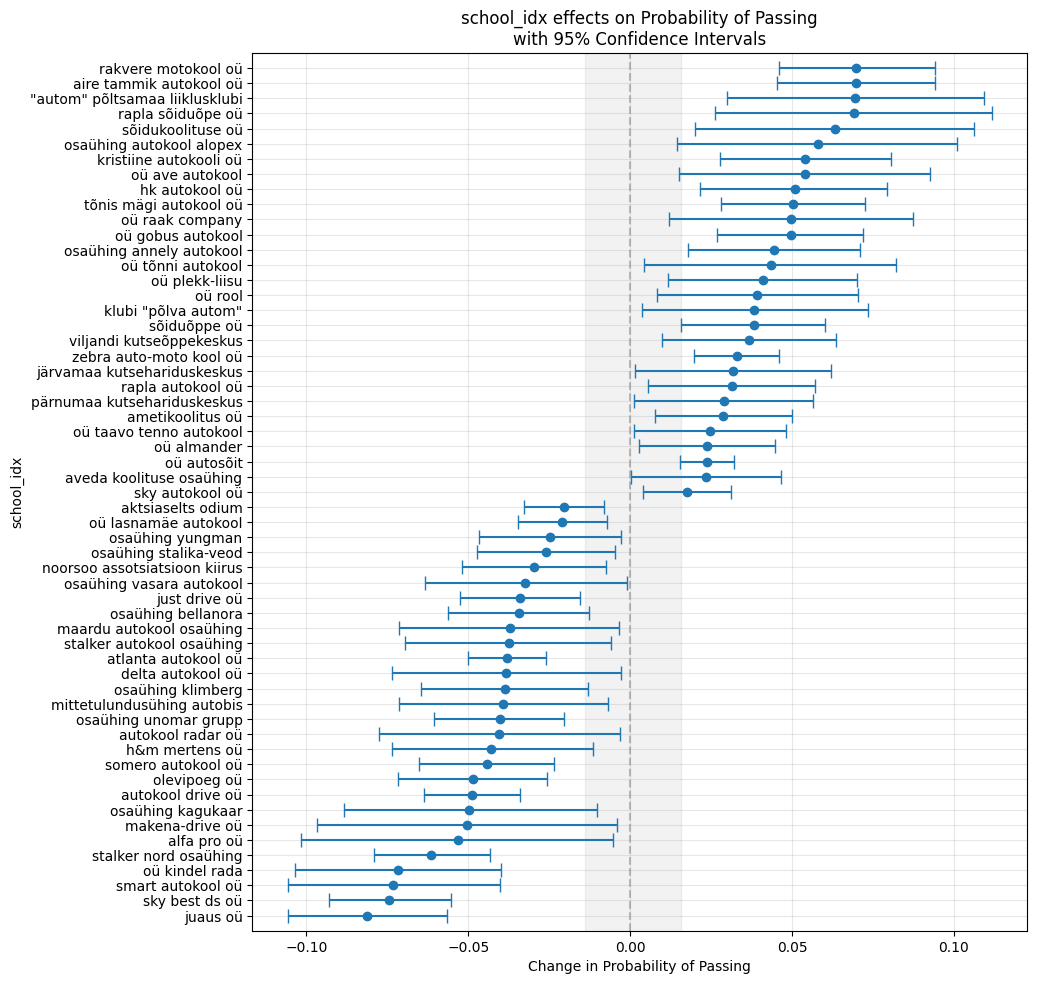

In [80]:
plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=True,
             y_dict=idx_to_school)

## Büroo effects

Number of byroo_idx with significant positive effect: 1
Number of byroo_idx with significant negative effect: 3


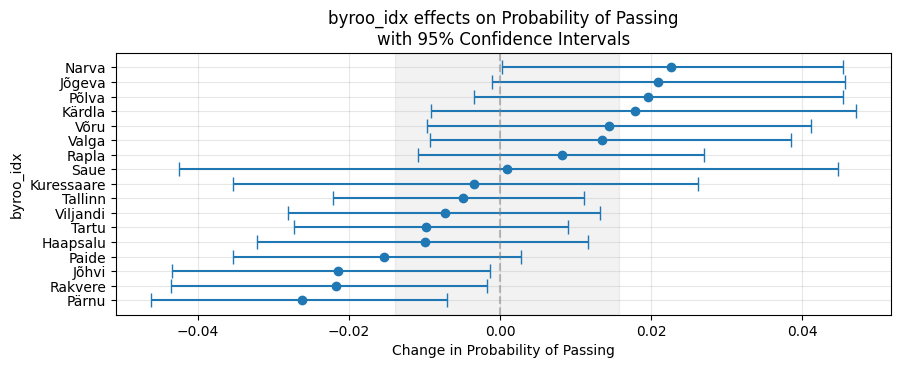

In [81]:
plot_effects(y_labels_col='byroo_idx', effects_key='byroo_effects', only_significant=False,
             y_dict=idx_to_byroo)

## Year effects

Number of year_idx with significant positive effect: 0
Number of year_idx with significant negative effect: 0


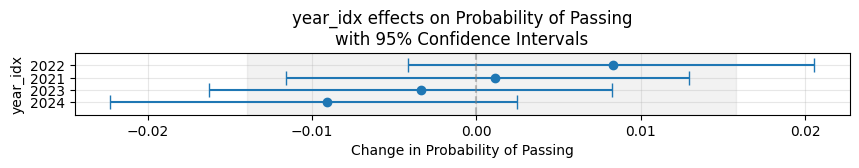

In [82]:
plot_effects(y_labels_col='year_idx', effects_key='year_effects', only_significant=False,
             y_dict=idx_to_year)

## Day of week effect

Number of dow_idx with significant positive effect: 0
Number of dow_idx with significant negative effect: 0


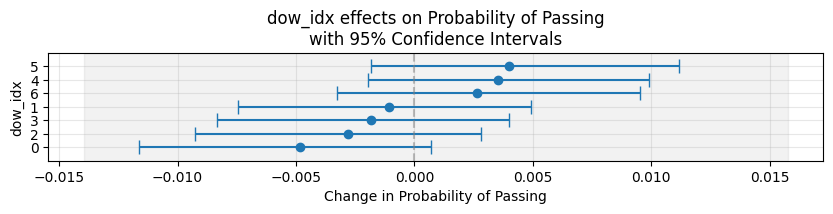

In [83]:
plot_effects(y_labels_col='dow_idx', effects_key='dow_effects', only_significant=False,
             y_dict=idx_to_dow)

In [62]:
df_b_sub.dow.value_counts()

dow
0    22264
4    21055
2    18282
3    17723
1    17384
5    14150
6    13844
Name: count, dtype: int64

## Month effects

In [58]:
def plot_separate_time_effects_with_ci():
    # Get time coefficients and all samples
    time_betas_samples = trace.posterior['time_betas'].values
    
    # Create figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    
    # Create time points
    days = np.linspace(1, 365, 100)
    month_in_year = days / 365 * 12
    
    # Calculate monthly cyclical features
    month_sin = np.sin(2 * np.pi * month_in_year / 12)
    month_cos = np.cos(2 * np.pi * month_in_year / 12)
    
    # Calculate effects for all samples
    n_samples = time_betas_samples.shape[0] * time_betas_samples.shape[1]
    month_effects = np.zeros((n_samples, len(days)))
    
    # Reshape samples for easier processing
    time_betas_flat = time_betas_samples.reshape(-1, time_betas_samples.shape[-1])
    
    # Calculate monthly effects for all samples
    for i, sample in enumerate(time_betas_flat):
        month_effect = (sample[0] * month_sin + sample[1] * month_cos)
        month_effects[i] = sp.expit(intercept_mean + month_effect) - sp.expit(intercept_mean)
    
    # Calculate mean and confidence intervals
    month_mean = np.mean(month_effects, axis=0)
    month_ci = np.percentile(month_effects, [3, 97], axis=0)
    
    # Plot monthly effect with CI
    ax1.plot(days, month_mean, label='Monthly Effect', color='blue')
    ax1.fill_between(days, month_ci[0], month_ci[1], alpha=0.2, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Day of Year')
    ax1.set_ylabel('Change in Probability')
    ax1.set_title('Monthly Seasonal Effect with 94% CI')
    ax1.grid(True, alpha=0.3)
    
    # Add month labels
    month_positions = np.linspace(1, 365, 12)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax1.set_xticks(month_positions)
    ax1.set_xticklabels(month_names)
    
    # Print the ranges of effects with CI
    print(f"Monthly effect range: {month_mean.min():.3f} to {month_mean.max():.3f}")
    print(f"Monthly CI width: {np.mean(month_ci[1] - month_ci[0]):.3f}")

Monthly effect range: -0.004 to 0.004
Monthly CI width: 0.004


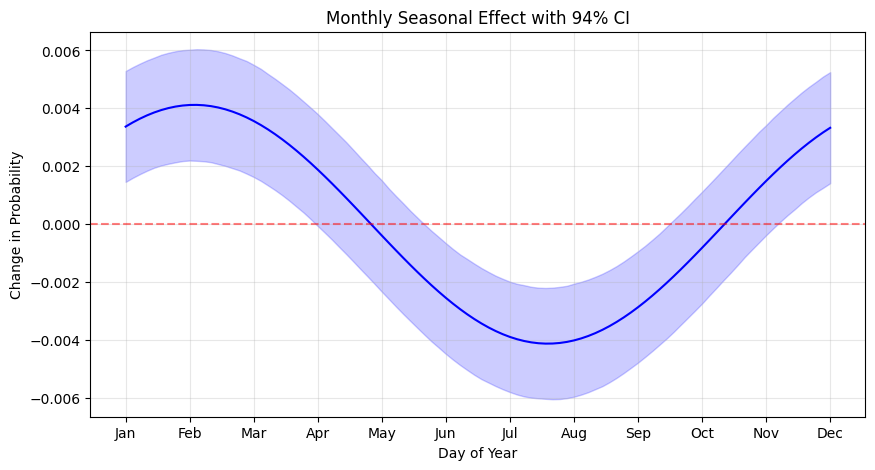

In [59]:
plot_separate_time_effects_with_ci()

<Axes: xlabel='month'>

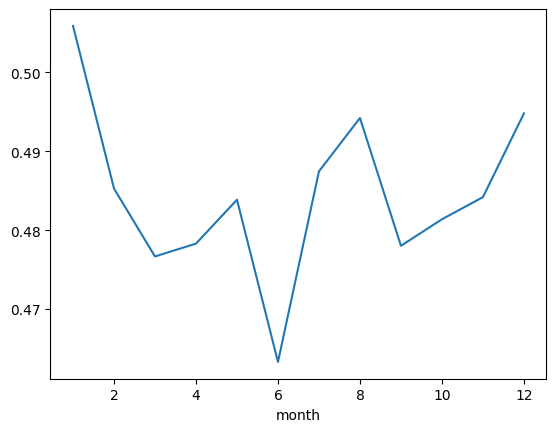

In [64]:
df_b_sub.groupby('month')['y'].mean().plot()

<Axes: xlabel='month'>

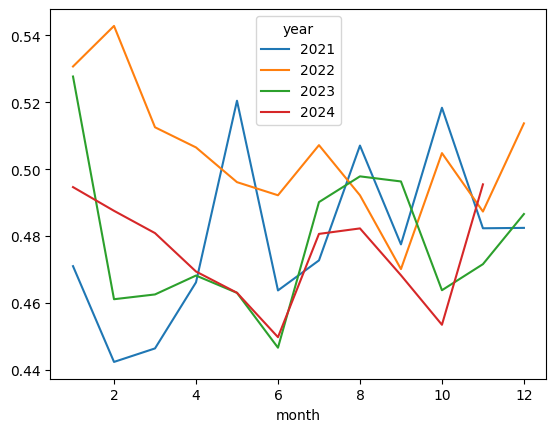

In [70]:
df_b_sub.groupby(['year','month'])['y'].mean().unstack().T.plot()